In [27]:
# Import necessary packages
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read in data from FRED
start_date = "2000-01-01"
end_date = "2023-09-01"

consumer_confidence = web.DataReader("UMCSENT", "fred", start_date, end_date)
savings_rate = web.DataReader("PSAVERT", "fred", start_date, end_date)

# Merging datasets
data = pd.concat([consumer_confidence, savings_rate], axis=1)
data.columns = ['Consumer Confidence', 'Savings Rate']

In [3]:
data.isnull().sum()

Consumer Confidence    0
Savings Rate           0
dtype: int64

In [30]:
### Feature engineering ###

# Lag feature
for i in range(1, 13):  
    data[f'lag_{i}'] = data['Consumer Confidence'].shift(i)

# Rolling window statistics    
data['rolling_mean'] = data['Consumer Confidence'].rolling(window=12).mean()
data['rolling_std'] = data['Consumer Confidence'].rolling(window=12).std()

# Differencing
data['diff_1'] = data['Consumer Confidence'].diff(1)

# Date and time features
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['weekday'] = data.index.weekday

# Exponential weighted features
data['ewm'] = data['Consumer Confidence'].ewm(span=12, adjust=False).mean()

# Interactions
data['lag1_times_rolling_mean'] = data['lag_1'] * data['rolling_mean']

# Cyclical features
month_in_year = 12
data['month_sin'] = np.sin(2 * np.pi * data['month'] / month_in_year)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / month_in_year)

In [ ]:
# Split data
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]
train.dropna(inplace=True)

In [16]:
# Drop target variable
X_train = train.drop('Consumer Confidence', axis=1)
y_train = train['Consumer Confidence']

X_test = test.drop('Consumer Confidence', axis=1)
y_test = test['Consumer Confidence']

In [17]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [20]:
# Create model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [28]:
# Predict with model and show accuracy
y_pred = rf_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.2f}")

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2:.2f}")

Mean Squared Error on the test set: 15.04
Root Mean Squared Error (RMSE): 3.88
Coefficient of Determination (R^2): 0.93


In [22]:
# Show feature importance
importance = rf_model.feature_importances_
for i, j in enumerate(importance):
    print(f"Feature {X_train.columns[i]}: {j:.4f}")

Feature Savings Rate: 0.0021
Feature lag_1: 0.3865
Feature lag_2: 0.0025
Feature lag_3: 0.0019
Feature lag_4: 0.0019
Feature lag_5: 0.0014
Feature lag_6: 0.0024
Feature lag_7: 0.0012
Feature lag_8: 0.0010
Feature lag_9: 0.0012
Feature lag_10: 0.0021
Feature lag_11: 0.0019
Feature lag_12: 0.0016
Feature rolling_mean: 0.0011
Feature rolling_std: 0.0029
Feature diff_1: 0.0598
Feature year: 0.0093
Feature month: 0.0013
Feature day: 0.0000
Feature weekday: 0.0013
Feature ewm: 0.0355
Feature lag1_times_rolling_mean: 0.4788
Feature month_sin: 0.0011
Feature month_cos: 0.0010


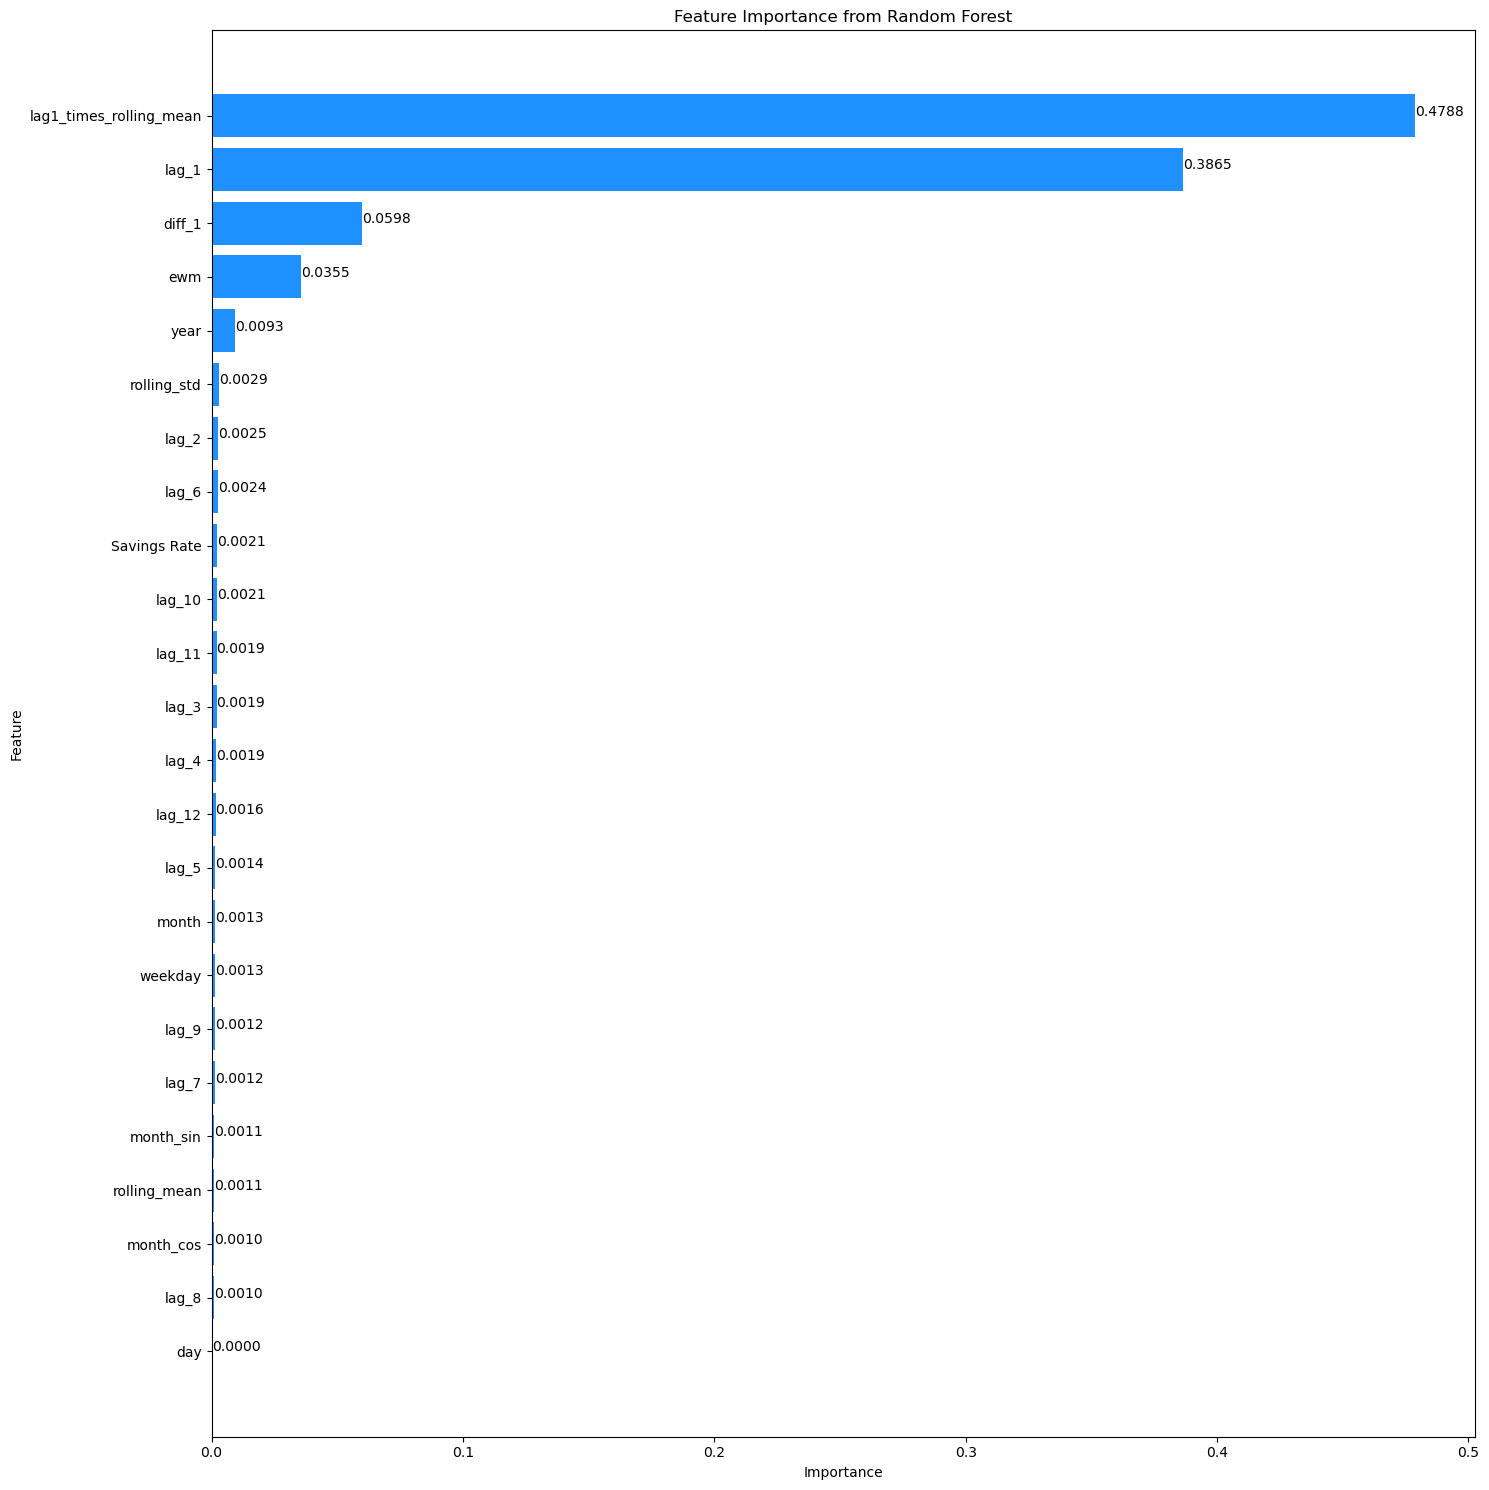

In [31]:
import matplotlib.pyplot as plt

# Extract feature importances from the model
importance = rf_model.feature_importances_

# Prepare data for visualization
features = X_train.columns
sorted_idx = importance.argsort()

# Plot feature importance
plt.figure(figsize=(15, 15))  # Adjust figure size here
plt.barh(features[sorted_idx], importance[sorted_idx], color='dodgerblue')

# Adding data labels
for index, value in enumerate(importance[sorted_idx]):
    plt.text(value, index, f"{value:.4f}")

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


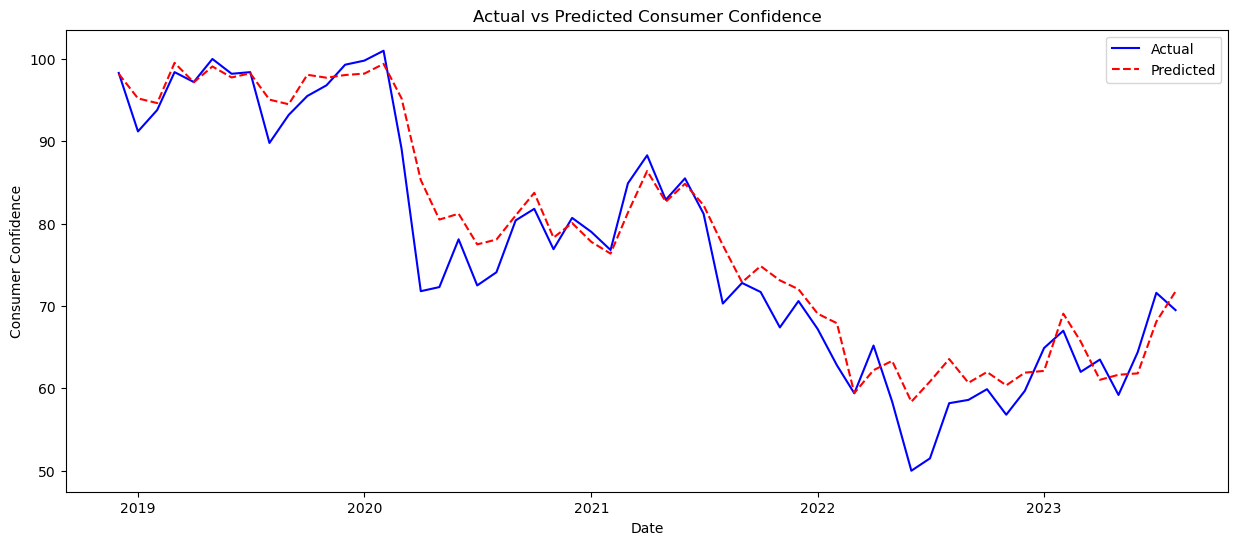

In [23]:
# Plot predictions vs actuals
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Consumer Confidence')
plt.xlabel('Date')
plt.ylabel('Consumer Confidence')
plt.legend()
plt.show()